# Busqueda Adversaria

## Juego del gato

El juego del gato consta en un tablero de 3x3 donde cada jugador marca con un signo distintivo (o y x) una casilla. El jugador que pueda completar un renglón, una columna o una diagonal con sólo los signos que le corresponden ganará el juego.

Para simular esto, tenemos que determinar una función que nos diga cuando las variables (casillas del tablero) son iguales, para identificar cuando se ha completado un juego ganador.

In [1]:
import numpy as np
from itertools import combinations

def allsim(variables):
    """Revisa si son similares todas las variables"""
    for x_i,x_j in combinations(variables, 2):
        if x_i != x_j:
            return False

    return True

Nuestro simulador para jugar gato consistirá en un tablero de 3x3
 (una matriz) en donde cada jugador colocará un símbolo, 'x' ó 'o', para intentar formar una fila, columna o diagonal con estos símbolos.


Definimos las siguientes funciones:

to_move: Determina quién es jugador al que le corresponde la jugada.

change_player: Cambia de jugador cuando se ha terminado una jugada.

actions: Regresa las coordenadas de las acciones posibles del estado actual del tablero; es decir, aquellas casillas que no han sido marcadas.

result: Regresa el resultado de la acción (marcar una casilla) dado el estado actual del tablero.

is_terminal: Revisa si el estado actual del tablero es un estado final, es decir, si alguno de los dos jugadores ha ganado. Si es así regresa True.

utility: Es la función de utilidad definida como:

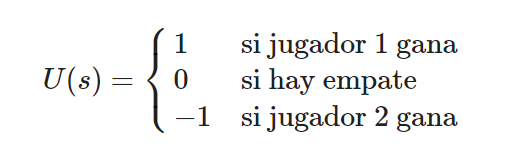

In [2]:
class Gato():
    """Clase para simular el juego de gato"""
    def __init__(self):
        #Tablero de 3x3
        self.board = np.zeros((3,3))
        #Guarda el jugador previo
        self.previous_player = None
        #Guarda el jugador actual
        self.player = 1

    def __str__(self):
        """Imprime tablero"""
        board = ''
        for row_i in self.board:
            row = '|'
            for val in row_i:
                if val == 0:
                    row += ' |'
                elif val == 1:
                    row += 'o|'
                else:
                    row += 'x|'
            board += row + '\n'

        return board

    def to_move(self):
        """Quién moverá en el turno"""
        return self.player

    def change_player(self):
        """Cambia el turno de cada jugador"""
        if self.player == 1:
            self.player = 2
        elif self.player == 2:
            self.player = 1

    def actions(self, state):
        """La posibles acciones que se pueden realizar"""
        #En dónde hay espacios para marcar
        return np.stack(np.where(state == 0)).T

    def result(self, state, action):
        """Resultado de la acción de cada jugador"""
        if self.player == 1:
            state[action[0],action[1]] = 1
            return state
        elif self.player == 2:
            state[action[0],action[1]] = -1
            return state

    def is_terminal(self, state):
        """Determina si un estado es final o no
        El estado es final si un renglón, columna o diagonal tienen los mismos símbolos"""
        rows, columns = False, False
        for i in range(3):
            rows = rows or allsim(list(state[i])+[1]) or allsim(list(state[i])+[-1])
            columns = columns or allsim(list(state.T[i])+[1]) or allsim(list(state.T[i])+[-1])
        diag1 = allsim([state[0,0],state[1,1],state[2,2],1]) or allsim([state[0,0],state[1,1],state[2,2],-1])
        diag2 = allsim([state[0,2],state[1,1],state[2,0],1]) or allsim([state[0,2],state[1,1],state[2,0],-1])
        draw = list(self.actions(state))==[]

        return rows or columns or diag1 or diag2

    def utility(self, state, player=1):
        """Función de utilidad de cada jugador"""
        if player == 1:
            w = 1
        else:
            w = -1

        if list(self.actions(state))==[]:
            return 0
        elif allsim([state[0,0],state[1,1],state[2,2]]):
                return w*state[1,1]
        elif allsim([state[0,2],state[1,1],state[2,0]]):
                return w*state[1,1]
        else:
            for i in range(3):
                if allsim(state[i]):
                    return w*state[i,1]
                elif allsim(state.T[i]):
                    return w*state[1,i]

In [3]:
game = Gato()
print(game)
print('Coordenadas de posibles movimientos:\n{}'.format(game.actions(game.board)))

| | | |
| | | |
| | | |

Coordenadas de posibles movimientos:
[[0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 1]
 [1 2]
 [2 0]
 [2 1]
 [2 2]]


Jugador actual: 1
| | | |
| |o| |
| | | |



Jugador actual: 2
| | |x|
| |o| |
| | | |



In [6]:
for i in range(7):
    print('Jugador actual: {}'.format(game.to_move()))
    #Selecciona acción aleatoriamente
    actions = game.actions(game.board)
    a = actions[np.random.choice(range(len(actions)))]
    #Realiza jugada
    game.board = game.result(game.board, a)
    game.change_player()
    print(game)

Jugador actual: 1
| | |x|
| |o|o|
| | | |

Jugador actual: 2
| | |x|
|x|o|o|
| | | |

Jugador actual: 1
|o| |x|
|x|o|o|
| | | |

Jugador actual: 2
|o| |x|
|x|o|o|
| |x| |

Jugador actual: 1
|o| |x|
|x|o|o|
| |x|o|

Jugador actual: 2
|o| |x|
|x|o|o|
|x|x|o|

Jugador actual: 1
|o|o|x|
|x|o|o|
|x|x|o|



## Algoritmo de búsqueda Minimax

El algoritmo de búsqueda Minimax es un algoritmo para resolver problemas de búsqueda adversas. Las búsquedas adversarias se dan en entornos multi-agente y completitivos; **es decir, en aquellos entornos en donde maximizar la función de utilidad de un jugador afecta a la utilidad del otro o los otros jugadores.**

El algoritmo de Minimax se basa en un árbol de búsqueda en donde se representan los movimientos de los adversarios.

Por ejemplo, a partir del nodo raíz, el jugador 1, que llamaremos Max, será el que pueda realziar ciertos movimientos. De los nodos expandidos, el jugador 2, que llamaremos Min, podrá realizar diferentes movimientos de acuerdo a los nodos que ha expandido Max.

El árbol buscará un un camino hacia un estado final en que alguno de los dos jugadores, Min o Max, haya logrado una victoria, o en donde no se puedan expandir más nodos (lo que podría corresponder a un empate).

##Valores para Max y Min

Para el algoritmo de Minimax, ambos jugadores deben buscar los mejores movimientos para lograr ganar el juego. Para esto se definen dos funciones que determinan los movimientos posibles y los valores de estos movimientos. Los valores de Max comienzan en -∞ por lo que se buscarán maximizar sus valores, mientras que Min comienza en ∞ para buscar minimizar los valores.

De esta forma, la idea es que los dos jugadores, Max y Min, compitan, uno buscando maximizar el valor, mientras que el otro minimizándolo.

La estrategia de Max será como sigue:

* Comienza con un movimiento y un valor bajos.
* Se explorarán las acciones, y se verá el valor que Min podrá alcanzar con tal acción, si el valor de Min es mayor al valor actual de Max, se tomará esa acción.
* Esto se repetirá para todas las acciones, de tal forma que se elegirá la acción que tenga siempre el valor más alto para Max.

Para Min se hará lo mimso pero buscando la acción que minimice el valor. Estas funciones son recursivas y buscan los valores de utilidad que se han alcanzado al final de la búsqueda de los árboles para ir eligiendo las mejores acciones para cada jugador.

In [7]:
import numpy as np

def max_value(game, state):
    """Valores de los movimientos de Max"""
    if game.is_terminal(state):
        #Si el estado es terminal regresa la utilidad
        return game.utility(state), None

    #Valores se inicializan bajos
    v, move = -np.inf, -np.inf
    for a in game.actions(state):
        #Revisa los posibles movimientos de Min con acción a
        v2, a2 = min_value(game, game.result(state, a))
        #Si el posible movimiento de Min es mayor,
        #antícipalo y toma éste
        if v2 > v:
            v, move = v2, a
    return v, move

def min_value(game, state):
    """Valores de los movimientos de Min"""
    if game.is_terminal(state):
        #Si el estado es terminal regresa la utilidad
        return game.utility(state), None

    #Valores se inicializan altos
    v, move = np.inf, np.inf
    for a in game.actions(state):
        #Revisa los posibles movimientos de Max con acción a
        v2, a2 = max_value(game, game.result(state, a))
        #Si el posible movimiento de Max es menor,
        #antícipalo y toma éste
        if v2 < v:
            v, move = v2, a

    return v, move

## Algoritmo Minimax

El algoritmo de Minimax hará uso de las funciones anteriores para buscar maximizar las acciones de Max (si se utiliza la función de Min, buscará que este jugador gane).

El algoritmo simplemente llama a la función max_value para elegir la acción actual más conveniente en base al valor para este jugador. Esto lo repetirá hasta que el juego acabe. Cuando no pueda continuar (pues las búsquedas en el árbol se han agotado) regresará los valores obtenidos.

In [8]:

def minimax(game):
    """Algoritmo de búsqueda Minimax"""
    #Estado inicial del juego
    state = game.board
    #Guarda las jugadas realziadas
    jugadas = []
    value, move = max_value(game, state.copy())

    while True:
        #Obtiene valor y movimiento para Max
        value, move = max_value(game, state.copy())

        try:
            #Realiza la jugada y cambia de jugador
            state = game.result(state, move)
            jugadas.append((game.player, move))
            game.change_player()

        except:
            #Regresa el resultado final
            result = Gato()
            result.board = state
            return result, jugadas, value

In [10]:

#Creación del juego de gato
game = Gato()

#Aplicación del algoritmo
result, jugadas, utilidad = minimax(game)

#Imprime el resultado del juego
print(result)
#Imprime las jugadas realizadas
print('\nJugadas realizadas:')
for j in jugadas:
    print('\tPlayer: {} - Position: {}'.format(j[0], j[1]))
#Imprime la utilidad final
print('\nUtilidad:{}'.format(utilidad))

|o|x|o|
|x|o|x|
|o| | |


Jugadas realizadas:
	Player: 1 - Position: [0 0]
	Player: 2 - Position: [0 1]
	Player: 1 - Position: [0 2]
	Player: 2 - Position: [1 0]
	Player: 1 - Position: [1 1]
	Player: 2 - Position: [1 2]
	Player: 1 - Position: [2 0]

Utilidad:1.0
